<a href="https://colab.research.google.com/github/Pilot-Khadka/Lung_Disease_Classification/blob/train_small_dataset/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%ls

sample_data/


# Importing all libraries. Add libraries here

In [ ]:
import os
import shutil
import zipfile
import requests
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline
os.chdir("/content/drive/MyDrive")
!pip install black[jupyter] --quiet

<ipython-input-1-aa1268f6ed7b>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
os.getcwd()
!black /content/drive/MyDrive/Colab\ Notebooks/sandbox.ipynb

All done! ✨ 🍰 ✨
1 file left unchanged.


In [ ]:
# create second folder called Dataset2 for undersampling using 1094 images for each class
import os
import random
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set the source and destination folders
src_folder = '/content/drive/MyDrive/Dataset'
dst_folder = '/content/drive/MyDrive/Dataset2'
flag = True

# create the destination folder
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
else:
    print(f"{dst_folder} already exist")
    flag = False

# create 3 subfolders in the destination folder if they do not exist
sub_folders = ['Normal', 'pnemo', 'tb']
for sub_folder in sub_folders:
    dst_path = os.path.join(dst_folder, sub_folder)
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

def copy_file(src_file, dst_file):
    shutil.copy2(src_file, dst_file)

if flag:
# copy 1094 random files from the source folders to the destination folders
    with ThreadPoolExecutor() as executor:
        for sub_folder in sub_folders:
            src_path = os.path.join(src_folder, sub_folder)
            dst_path = os.path.join(dst_folder, sub_folder)
            files = os.listdir(src_path)
            selected_files = random.sample(files, 1094)
            for file in selected_files:
                src_file = os.path.join(src_path, file)
                dst_file = os.path.join(dst_path)
                executor.submit(copy_file, src_file, dst_file)


# Print the number of files in each subfolder
for sub_folder in sub_folders:
    dst_path = os.path.join(dst_folder, sub_folder)
    files = os.listdir(dst_path)
    print(f"Number of files in {dst_path}: {len(files)}")


/content/drive/MyDrive/Dataset2 already exists. Not copying files.
Number of files in /content/drive/MyDrive/Dataset2/Normal: 1094
Number of files in /content/drive/MyDrive/Dataset2/pnemo: 1094
Number of files in /content/drive/MyDrive/Dataset2/tb: 1094


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_width = 224
img_height = 224
train_validation_seed = 3

data_dir = "/content/drive/MyDrive/Dataset2"
class_names = ["Normal", "Pneumonia", "TB"]


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
     subset="training",
     seed=train_validation_seed,
     image_size=(img_height, img_width),
     batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.3,
    subset = "validation",
    seed = train_validation_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 3)
val_ds = val_ds.skip((1*val_batches) // 3)

Found 3282 files belonging to 3 classes.
Using 2298 files for training.
Found 3282 files belonging to 3 classes.
Using 984 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'pnemo', 'tb']


In [ ]:
# Normalizing the dateset 
def process(image, label):
  image = tf.cast(image/255., tf.float32)
  return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
train_ds = train_ds.shuffle(2298, reshuffle_each_iteration=False)
val_ds = val_ds.shuffle(984,reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

72
21


In [ ]:
# using prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
72/72 [==============================] - 1008s 4s/step - loss: 0.8804 - accuracy: 0.6010 - val_loss: 0.6968 - val_accuracy: 0.7063
Epoch 2/20
72/72 [==============================] - 7s 91ms/step - loss: 0.6462 - accuracy: 0.7341 - val_loss: 0.6804 - val_accuracy: 0.7214
Epoch 3/20
72/72 [==============================] - 7s 91ms/step - loss: 0.6027 - accuracy: 0.7567 - val_loss: 0.6286 - val_accuracy: 0.7530
Epoch 4/20
72/72 [==============================] - 7s 92ms/step - loss: 0.5485 - accuracy: 0.7750 - val_loss: 0.6153 - val_accuracy: 0.7636
Epoch 5/20
72/72 [==============================] - 7s 92ms/step - loss: 0.5243 - accuracy: 0.7772 - val_loss: 0.6183 - val_accuracy: 0.7636
Epoch 6/20
72/72 [==============================] - 7s 92ms/step - loss: 0.4946 - accuracy: 0.7942 - val_loss: 0.5836 - val_accuracy: 0.7786
Epoch 7/20
72/72 [==============================] - 7s 93ms/step - loss: 0.4840 - accuracy: 0.8072 - val_loss: 0.5789 - val_accuracy: 0.7846
Epoch 8/20
7

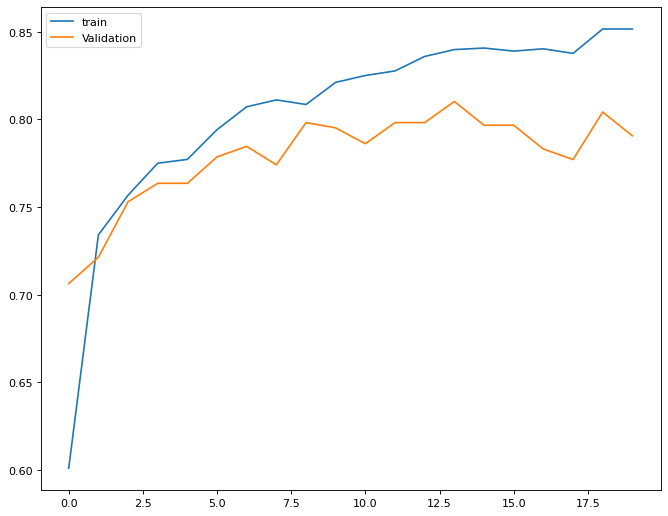

In [ ]:
# Plotting Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.show()

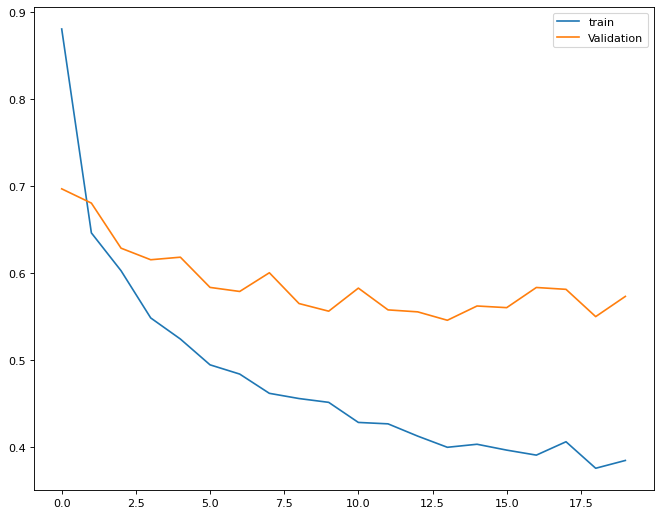

In [ ]:
# Plotting Loss
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()

In [ ]:
from keras.applications import ResNet50

#Importing resnet50,preparing the base convolution 
conv_base = ResNet50(
    weights= 'imagenet',
    include_top = False,
    input_shape = (224, 224,3))

conv_base.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Preaparing our model 
from keras.activations import relu, linear
from keras.layers import Dense, Flatten 
from keras.models import Sequential
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation= 'linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam',
              metrics = ['accuracy']
              )

In [ ]:
#Training the Data, training with gpu
history = model.fit(train_ds, epochs =15 , validation_data = val_ds)

Epoch 1/15
72/72 [==============================] - 15s 159ms/step - loss: 4.2107 - accuracy: 0.3708 - val_loss: 1.1222 - val_accuracy: 0.3389
Epoch 2/15
72/72 [==============================] - 9s 131ms/step - loss: 1.0510 - accuracy: 0.4748 - val_loss: 0.9422 - val_accuracy: 0.6220
Epoch 3/15
72/72 [==============================] - 9s 132ms/step - loss: 0.9606 - accuracy: 0.5383 - val_loss: 0.8970 - val_accuracy: 0.6401
Epoch 4/15
72/72 [==============================] - 10s 133ms/step - loss: 0.9089 - accuracy: 0.5744 - val_loss: 0.8774 - val_accuracy: 0.6491
Epoch 5/15
72/72 [==============================] - 10s 133ms/step - loss: 0.8632 - accuracy: 0.5962 - val_loss: 0.8362 - val_accuracy: 0.6672
Epoch 6/15
72/72 [==============================] - 10s 134ms/step - loss: 0.8231 - accuracy: 0.6214 - val_loss: 0.8012 - val_accuracy: 0.6822
Epoch 7/15
72/72 [==============================] - 9s 132ms/step - loss: 0.7901 - accuracy: 0.6510 - val_loss: 0.7846 - val_accuracy: 0.6958
Ep

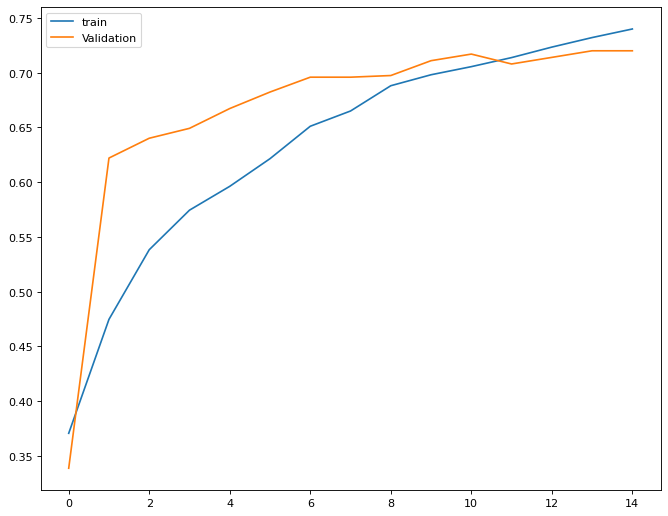

In [ ]:
# Plotting Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.show()

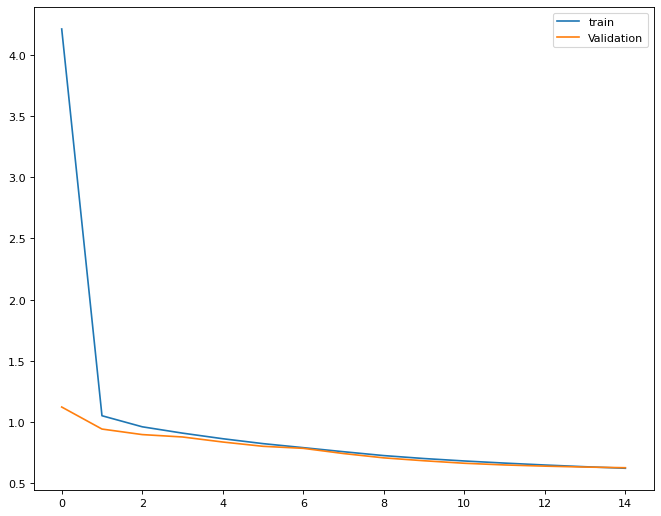

In [ ]:
# Plotting Loss
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()